In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import numpy as np
import torch

from p3droslo.loss  import Loss
from p3droslo.model import TensorModel, SphericallySymmetric

from test_1D                          import get_model, get_obs, forward, forward_N_lines, frequencies, velocities, r_in, v_fac, analytic_velo, analytic_T
from test_1D_CO_and_T_and_vel_N_lines import get_initial_model, reconstruct_N_lines, fit_N_lines

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=5-4)
Please check the properties that were inferred:
    Frequency         5.762679305e+11  Hz
    Einstein A coeff  1.221000000e-05  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [2]:
from p3droslo.lines import Line
from astropy import constants

In [3]:
# Line data
lines = [Line('CO', i) for i in range(10)]

# Frequency data
vdiff = 300   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=4-3)
Please check the properties that were inferred:
    Frequency         4.610407682e+11  Hz
    Einstein A coeff  6.126000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=5-4)
Please check the properties that were inferred:
    Frequency         5.762679305e+11  Hz
    Eins

In [4]:
test_model_name = 'models/test_model_1D.h5'
spherical_model = get_model()
spherical_model.model_1D.save(test_model_name)

In [5]:
obss = forward_N_lines(spherical_model, lines, frequencies)

In [7]:
from astropy import constants, units

r_in  = (1.0e+2 * units.au).si.value
r_out = (1.0e+4 * units.au).si.value

v_in  = (1.0e+0 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

T_in    = (5.0e+3 * units.K).si.value
epsilon = 0.3

Mdot = (5.0e-6 * units.M_sun / units.yr).si.value

v    = lambda r: v_in + (v_inf - v_in) * (1.0 - r_in / r)**beta
T    = lambda r: T_in * (r_in / r)**epsilon
rho  = lambda r: Mdot / (4.0 * np.pi * r**2 * v(r))
n_CO = lambda r: 1.0e-4 * constants.N_A.si.value / 2.02 * rho(r)

spherical = get_initial_model(
    from_model = test_model_name,
    nCO        = 0.0,
    v_in       = v_in,
    v_inf      = v_inf,
    beta       = beta,
    tmp        = T_in,
    epsilon    = epsilon
)

r = spherical.model_1D.get_radius(origin=np.array([0]))
r[r<r_in] = r_in

spherical.model_1D['log_CO'] = np.log(n_CO(r))

/STER/frederikd/p3droslo/docs/src/examples/test_1D/test_1D_CO_and_T_and_vel_N_lines.py:20: RuntimeWarning: divide by zero encountered in log
  model_1D['log_CO'         ] = np.log(nCO) * np.ones(model_1D.shape)


log_v_in             6.907755278982137
log_v_inf            9.903487552536127
log_beta             -0.6931471805599453
log_T_in             8.517193191416238
log_epsilon          -1.2039728043259361


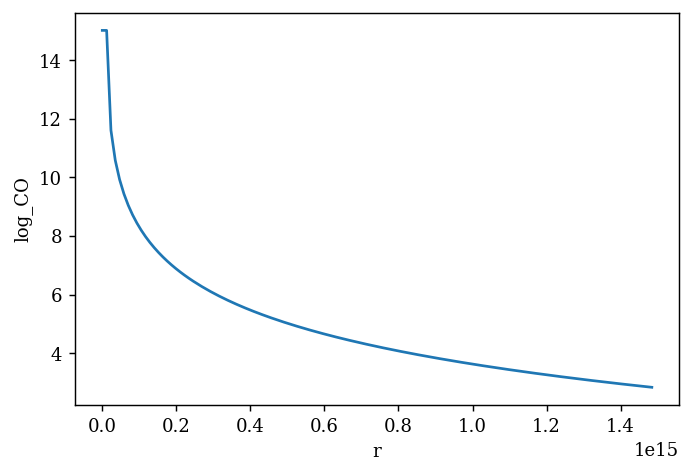

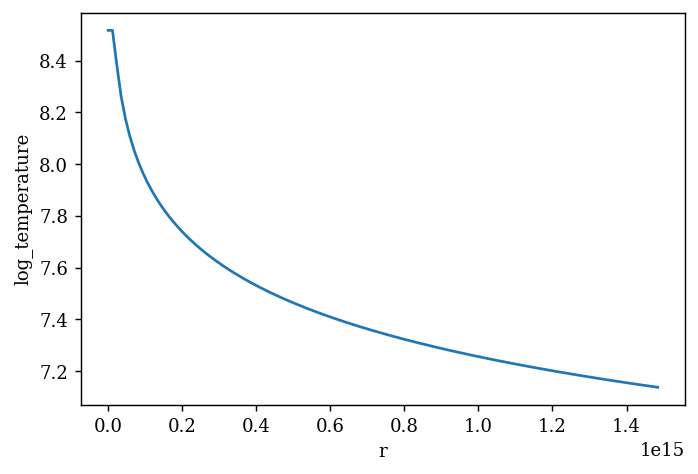

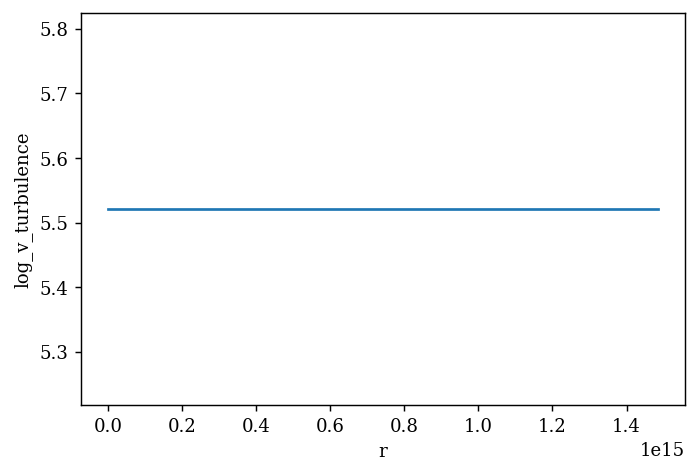

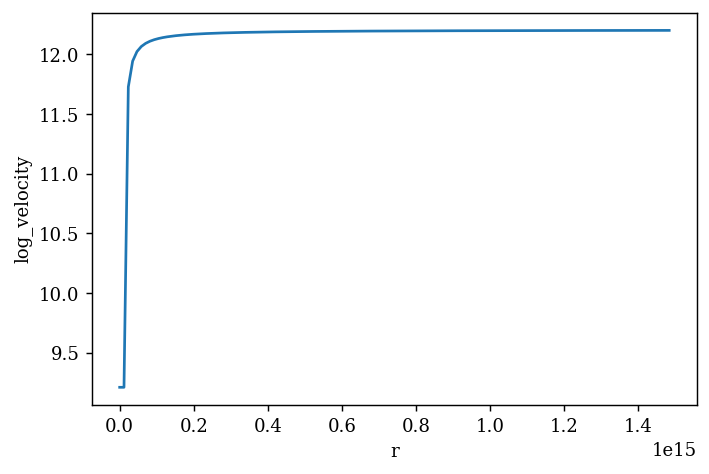

In [9]:
spherical.plot()

In [10]:
Is = forward_N_lines(spherical, lines, frequencies)

Text(0.5, 0, 'frequency [km/s]')

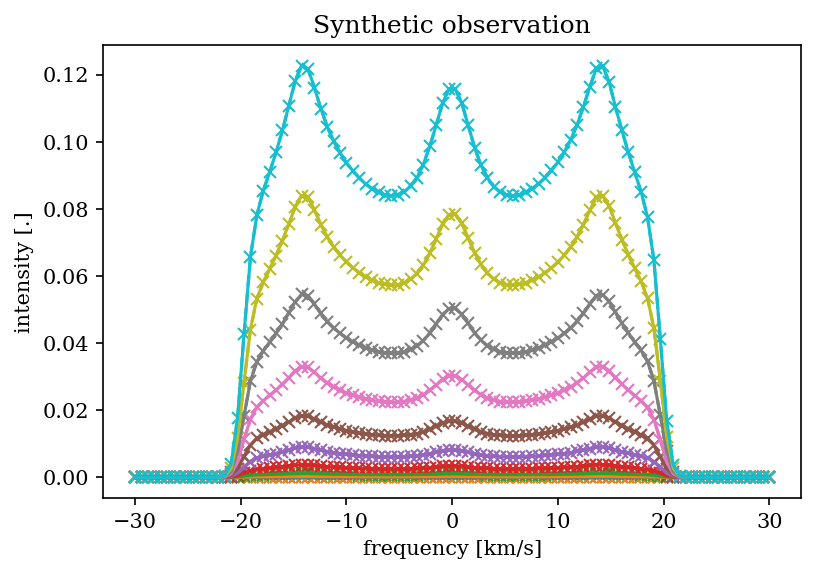

In [14]:
plt.figure(dpi=150)
plt.title("Synthetic observation")
for obs in obss[:]:
    plt.plot(velocities/1.0e+3, obs.data, linestyle='--', marker='x')
for I in Is[:]:
    plt.plot(velocities/1.0e+3, I.data)
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")
# plt.yscale('log')
# plt.ylim([1.0e-10, 10.0])

In [15]:
# # loss_keys  = [f'rep_{i}' for i in range(len(obss))]
# loss_keys  = ['rep']
# loss_keys += ['reg', 'cnt']
# loss = Loss(loss_keys)

losses = [Loss(['rep', 'reg', 'cnt']) for i in range(len(obss))]

In [16]:
imgs, loss = fit_N_lines(losses, spherical, lines, frequencies, obss, N_epochs=3  , lr=1.0e-1, w_rep=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

for loss in losses:
    loss.renormalise_all()
    loss.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:18<00:00,  6.30s/it]


In [17]:
imgs, losses = fit_N_lines(losses, spherical, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_rep=1.0e+0, w_reg=1.0e-1, w_cnt=1.0e+0) 

100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


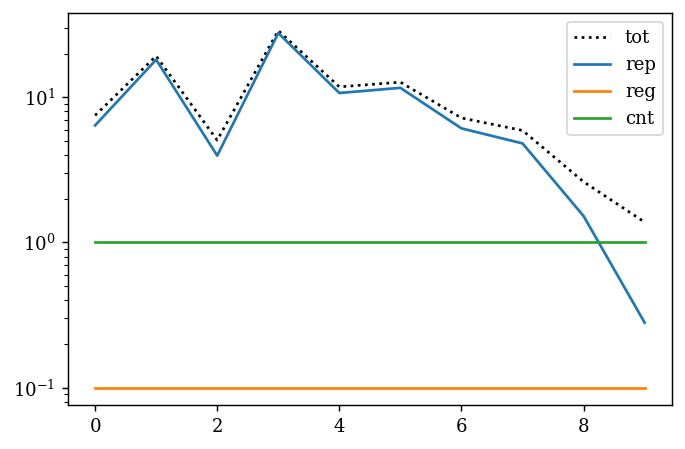

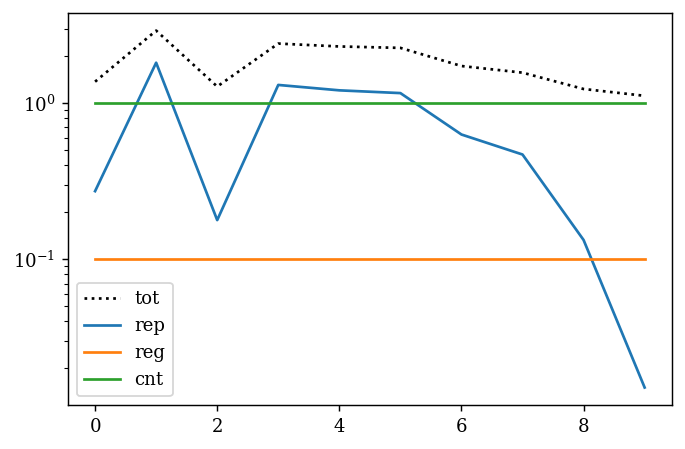

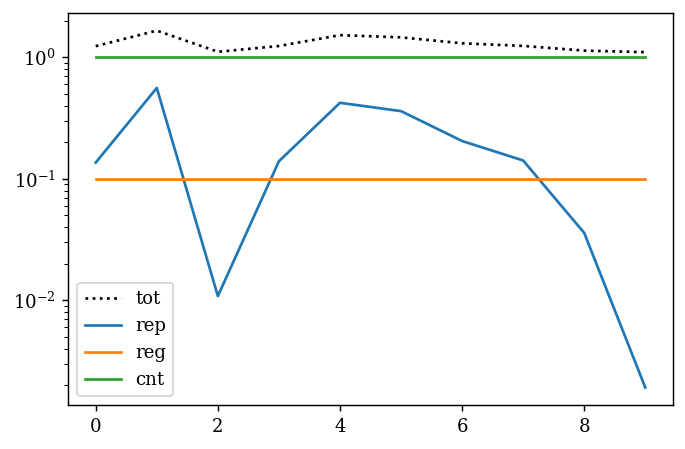

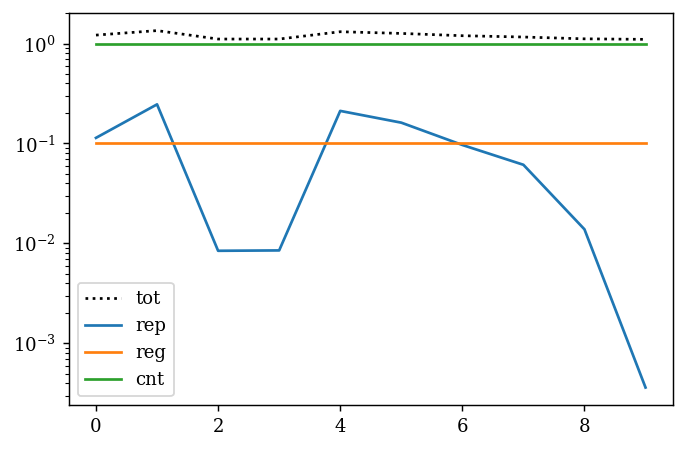

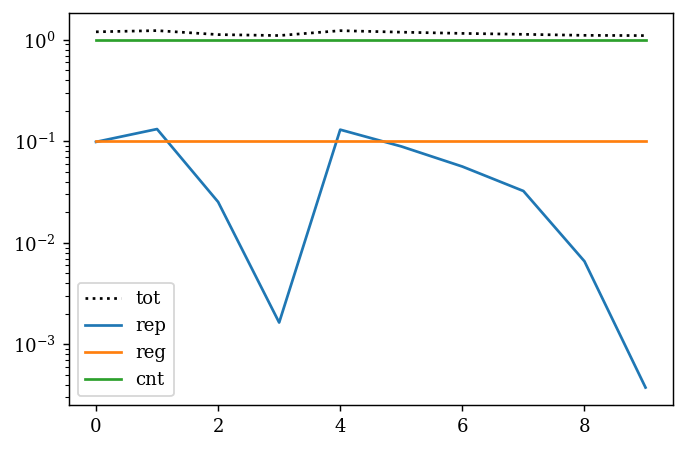

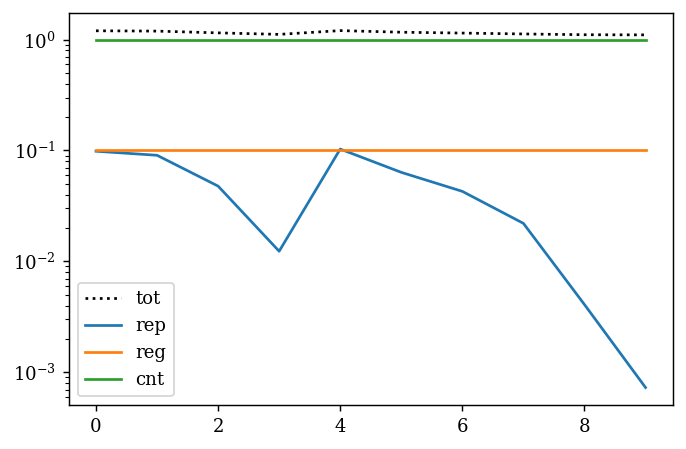

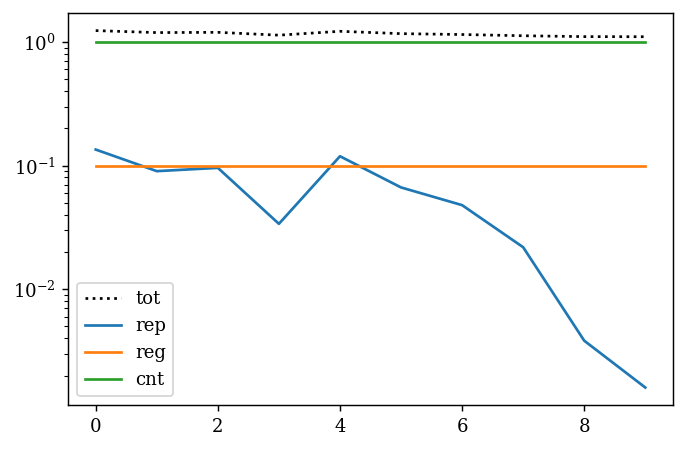

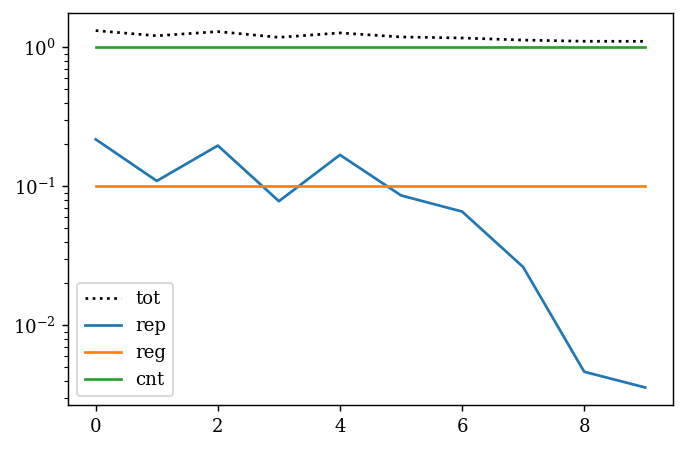

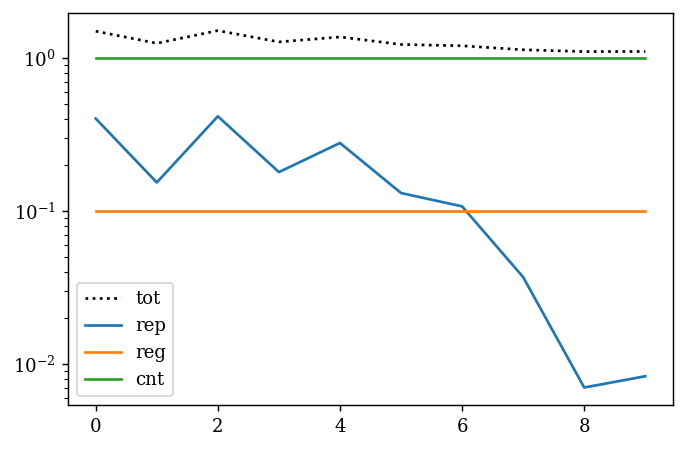

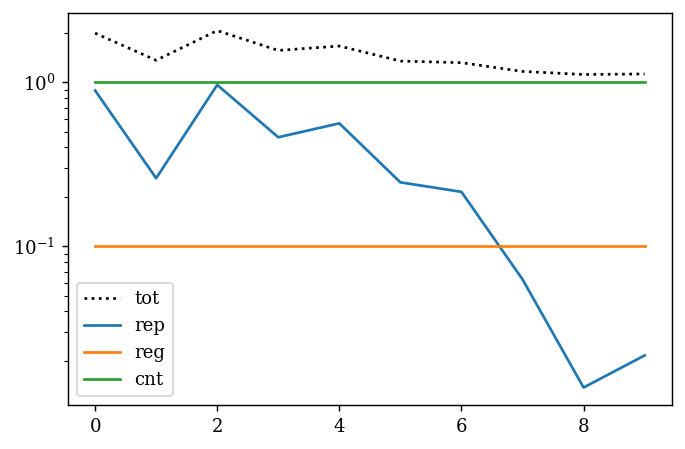

In [19]:
for loss in losses:
    loss.plot()

In [15]:
imgs, losses = fit_N_lines(losses, spherical, lines, frequencies, obss, N_epochs=100, lr=1.0e-1, w_rep=1.0e+0, w_reg=1.0e-1, w_cnt=1.0e+0) 

100%|██████████| 100/100 [10:29<00:00,  6.29s/it]


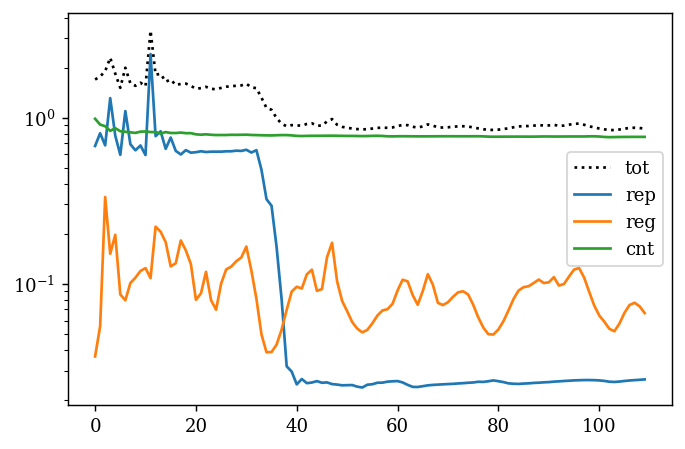

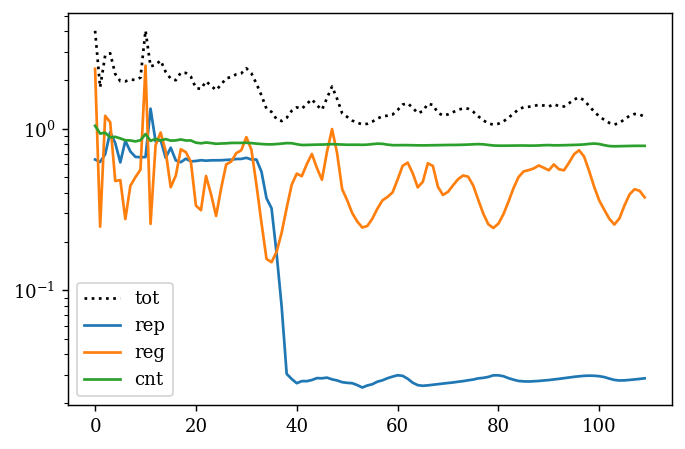

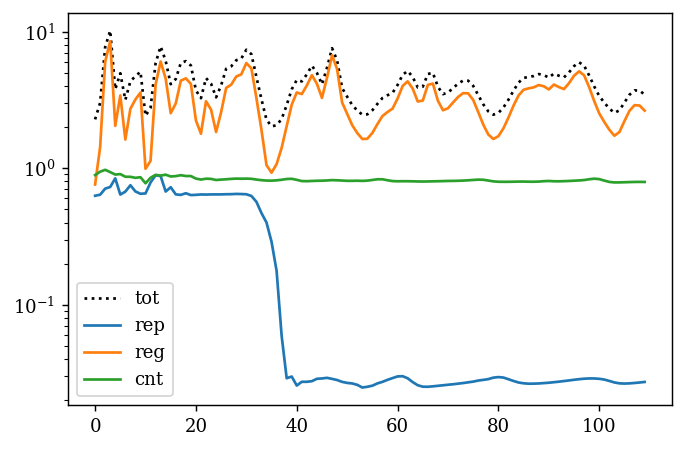

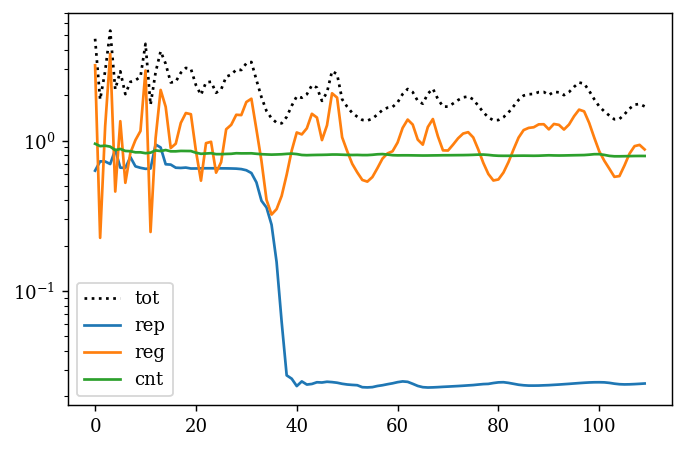

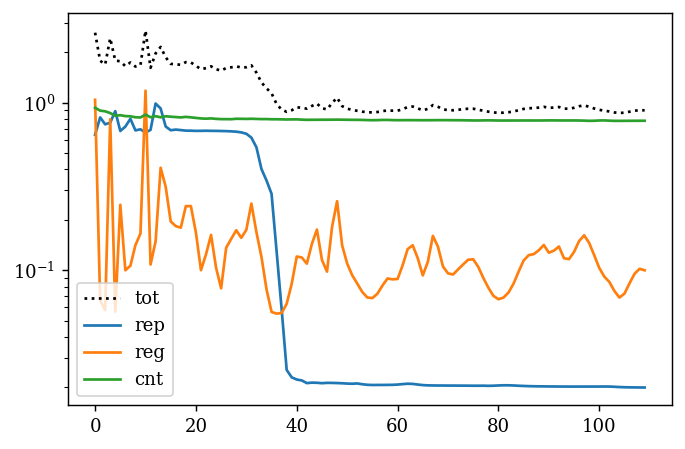

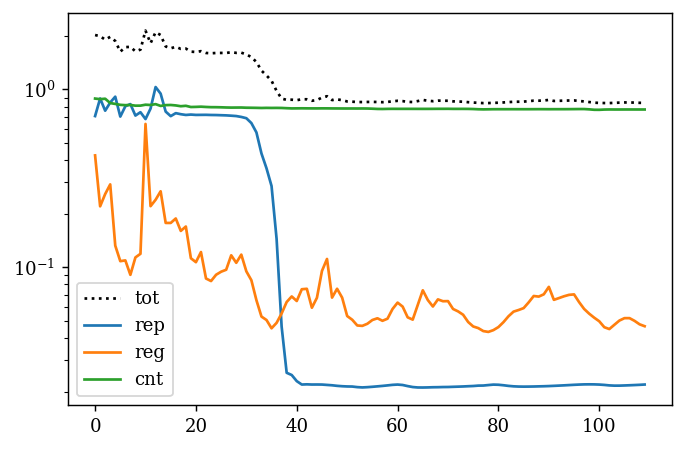

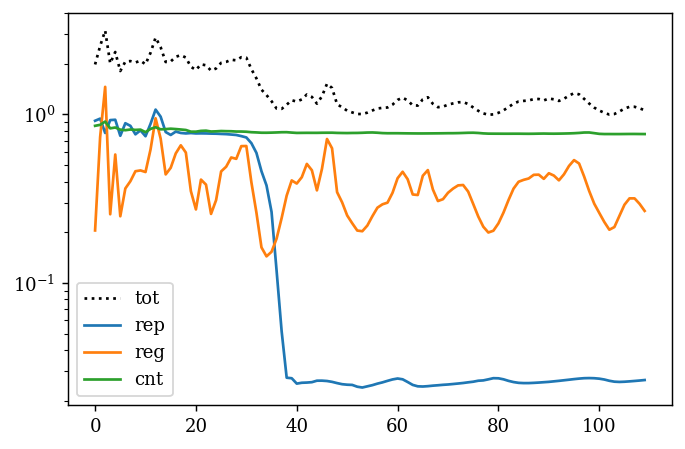

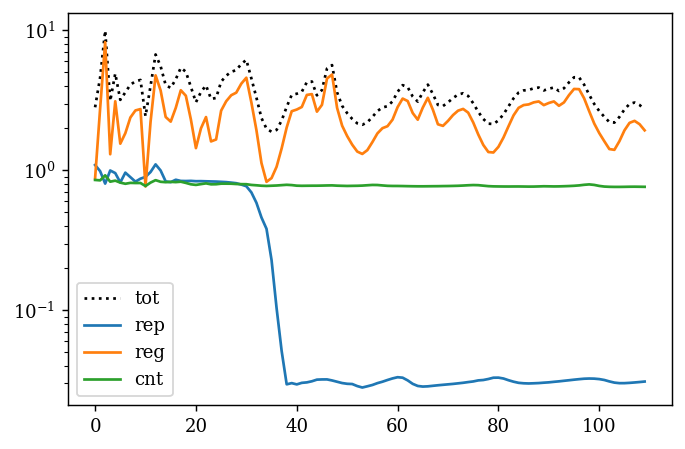

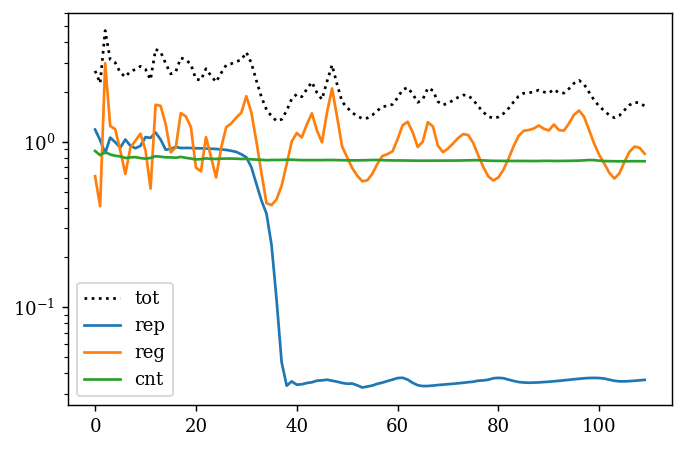

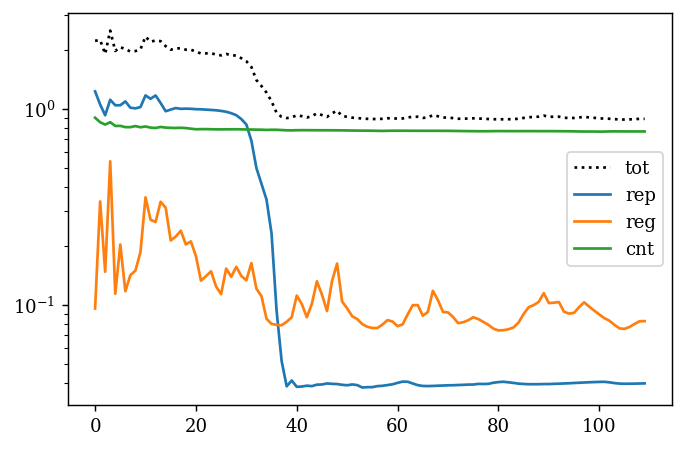

In [16]:
for loss in losses:
    loss.plot()

In [21]:
imgs, losses = fit_N_lines(losses, spherical, lines, frequencies, obss, N_epochs=100, lr=1.0e-1, w_rep=1.0e+2, w_reg=1.0e-1, w_cnt=1.0e+0) 

100%|██████████| 100/100 [10:06<00:00,  6.06s/it]


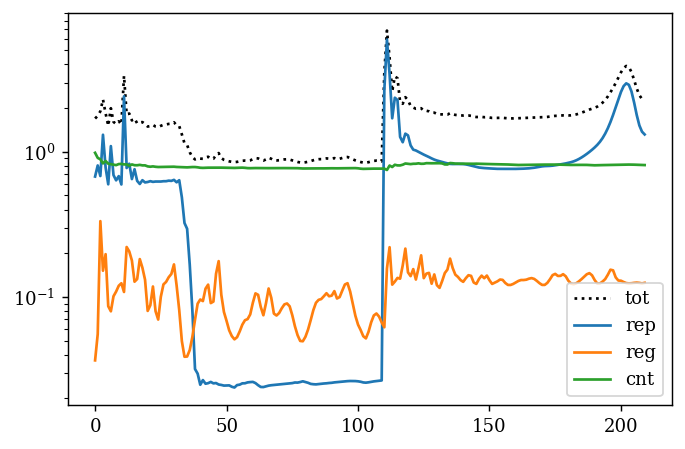

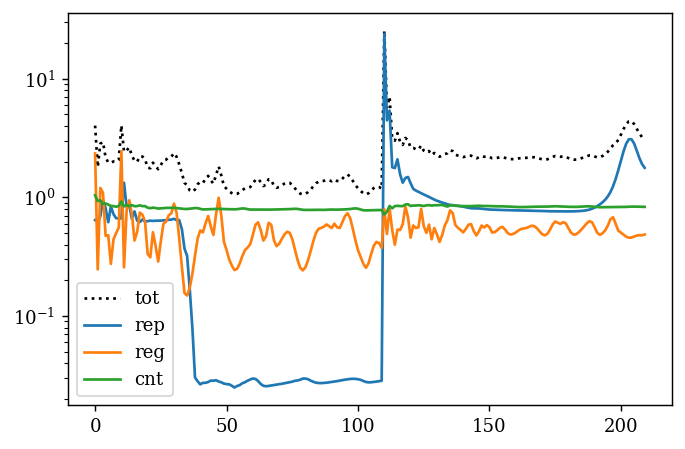

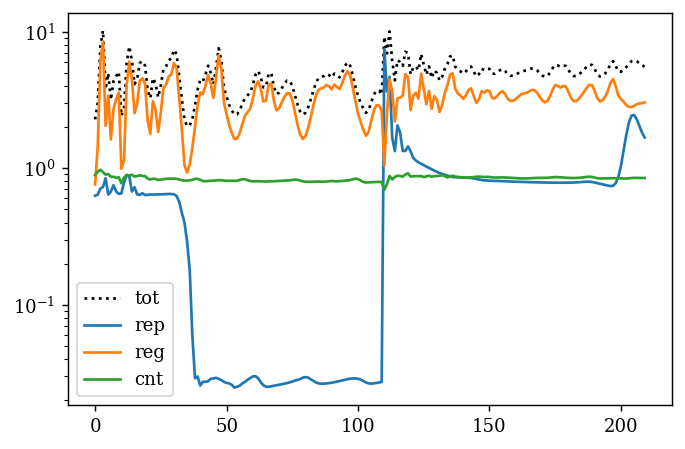

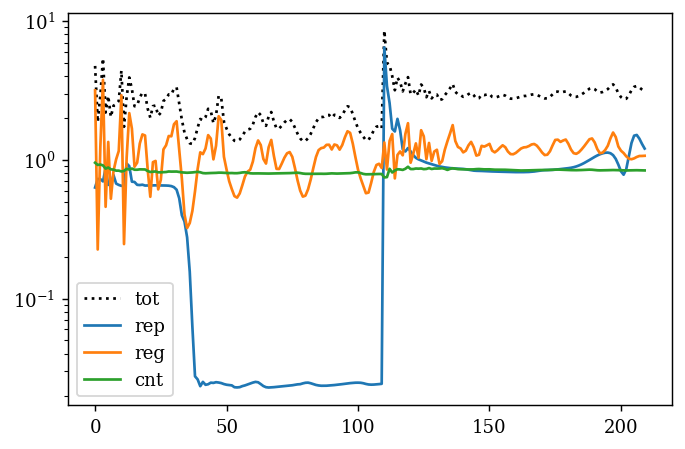

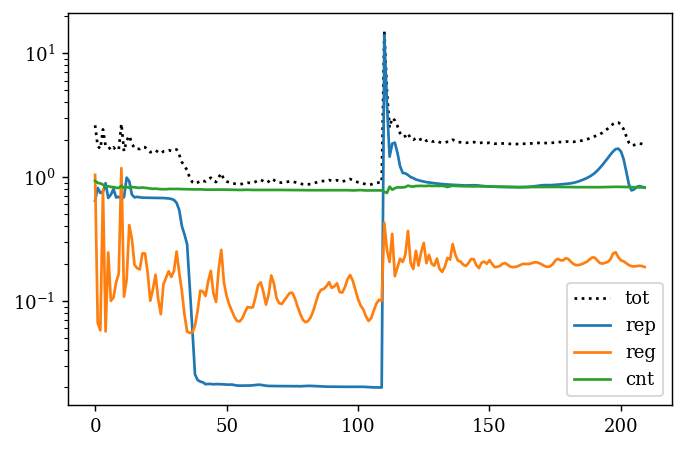

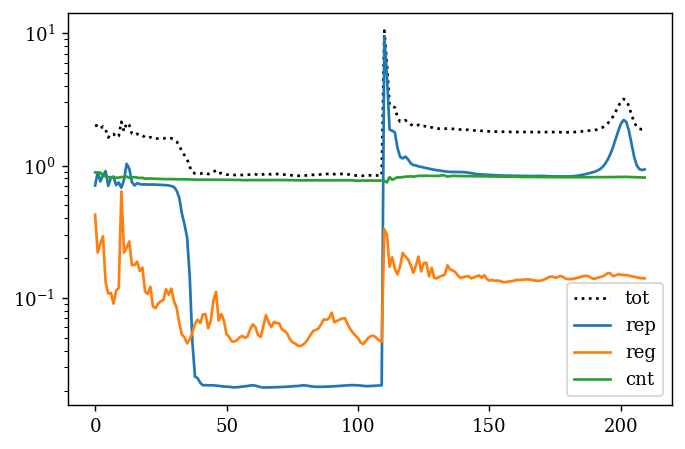

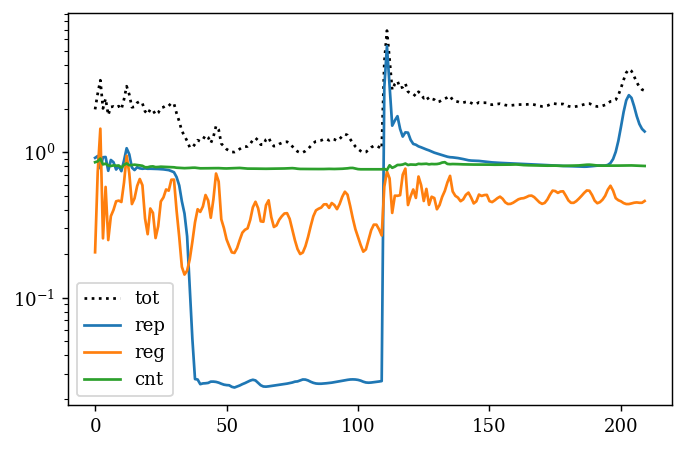

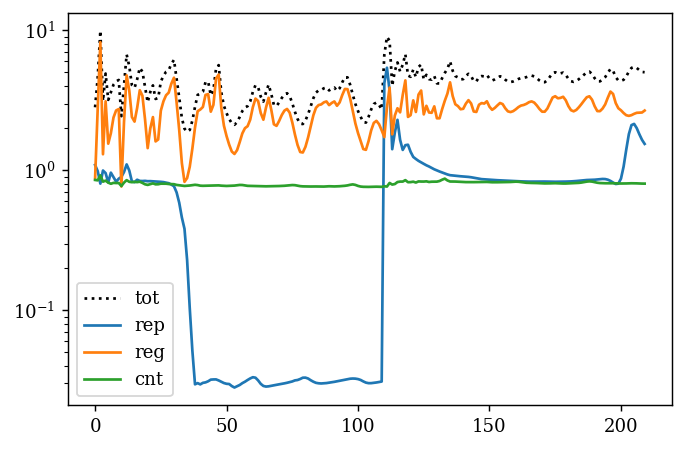

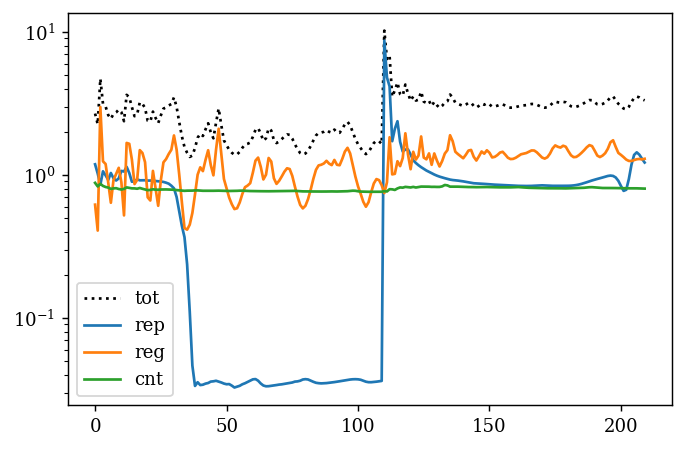

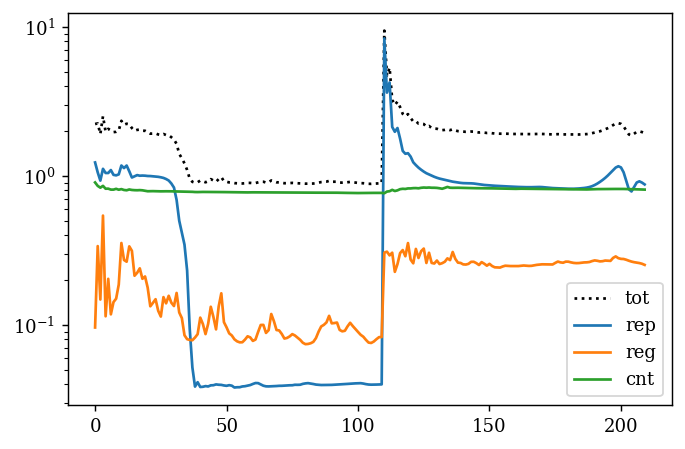

In [22]:
for loss in losses:
    loss.plot()

In [ ]:
imgs, loss = fit_N_lines(loss, spherical, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_rep=1.0e+0, w_reg=1.0e-1, w_cnt=1.0e+0) 

100%|██████████| 250/250 [20:55<00:00,  5.02s/it]


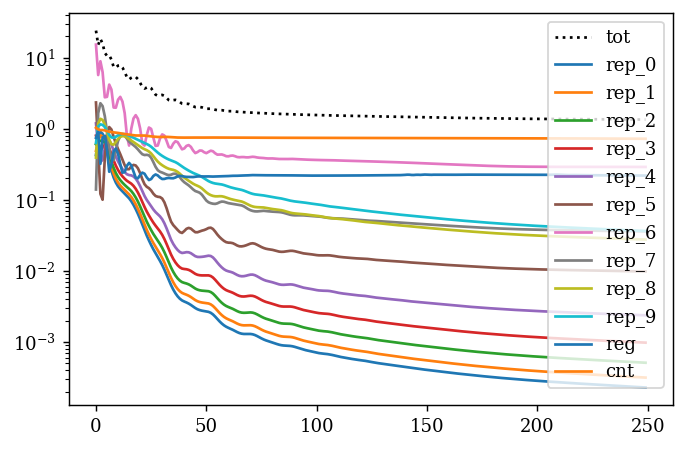

In [14]:
loss.plot()

In [16]:
imgs, loss = fit_N_lines(loss, spherical, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_rep=1.0e+2, w_reg=1.0e+0, w_cnt=1.0e+1)

100%|██████████| 250/250 [20:50<00:00,  5.00s/it]


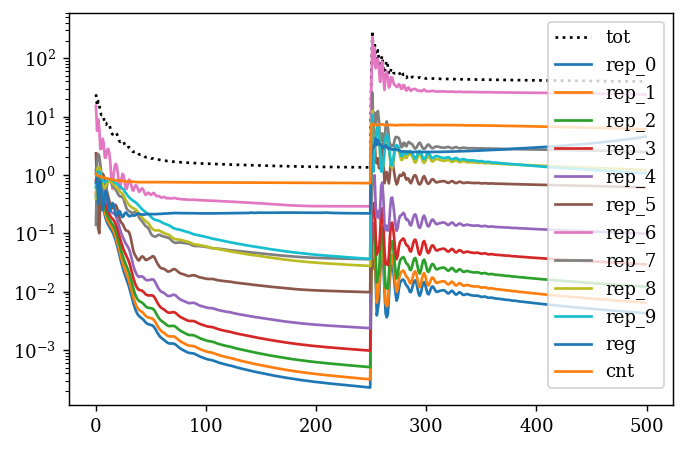

In [17]:
loss.plot()

In [22]:
imgs, loss = fit_N_lines(loss, spherical, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_rep=1.0e+3, w_reg=1.0e+0, w_cnt=5.0e+1)

100%|██████████| 250/250 [21:28<00:00,  5.15s/it]


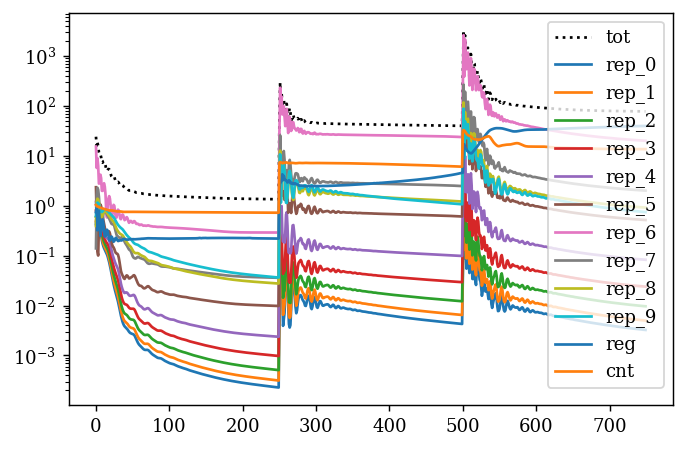

In [24]:
loss.plot()

In [30]:
imgs, loss = fit_N_lines(loss, spherical, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_rep=1.0e+5, w_reg=1.0e+0, w_cnt=5.0e+1)

100%|██████████| 250/250 [20:52<00:00,  5.01s/it]


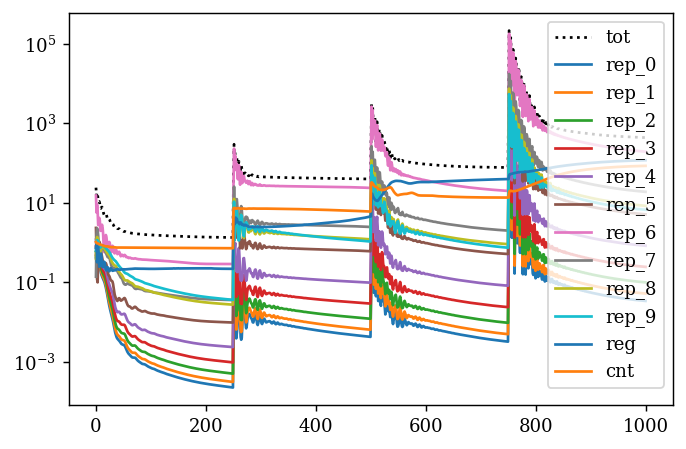

In [31]:
loss.plot()

In [20]:
Is = forward_N_lines(spherical, lines, frequencies)

Text(0.5, 0, 'frequency [km/s]')

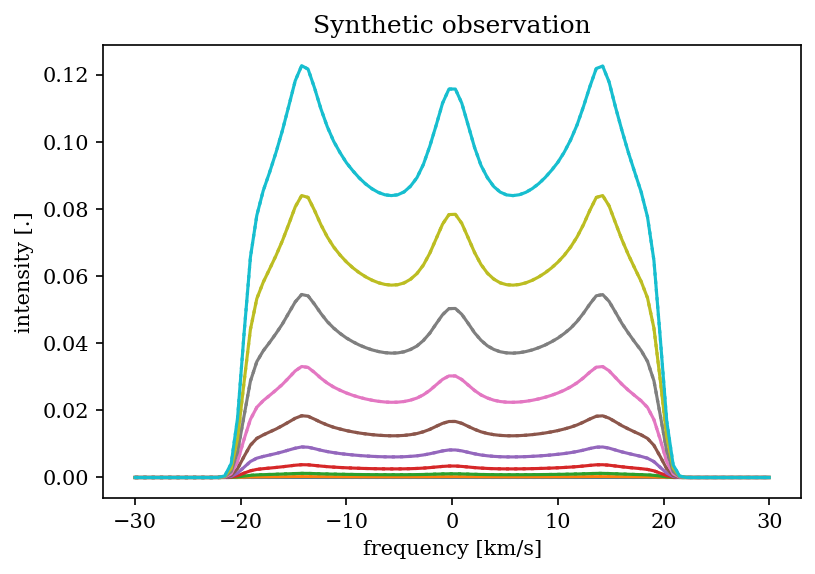

In [21]:
plt.figure(dpi=150)
plt.title("Synthetic observation")
for obs in obss[:]:
    plt.plot(velocities/1.0e+3, obs.data, linestyle=':')
for I in Is[:]:
    plt.plot(velocities/1.0e+3, I.data)
plt.ylabel(r"intensity [.]")
plt.xlabel(r"frequency [km/s]")
# plt.yscale('log')
# plt.ylim([1.0e-10, 10.0])

In [22]:
spherical.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Fixed         True     +2.836e+00     +4.902e+00     +1.502e+01
  log_temperature            Fixed         True     +7.138e+00     +7.438e+00     +8.517e+00
  log_v_turbulence           Fixed         True     +5.521e+00     +5.521e+00     +5.521e+00
  log_velocity               Fixed         True     +9.210e+00     +1.214e+01     +1.220e+01
  log_v_in                   Free          False    +6.480e+00     +6.480e+00     +6.480e+00
  log_v_inf                  Free          False    +9.884e+00     +9.884e+00     +9.884e+00
  log_beta                   Free          False    -4.075e-01     -4.075e-01     -4.075e-01
  log_T_in                   Free          False    +8.251e+00     +8.251e+00     +8.251e+00
  log_epsilon                Free          False    -1.394e+00     -1.394e+00     -1.394e+00
sizes: [1.49597871e+15]
shape: (128,)


log_v_in             6.479838393607285
log_v_inf            9.883959870347796
log_beta             -0.40753266775124447
log_T_in             8.25063366401498
log_epsilon          -1.3939952410925334


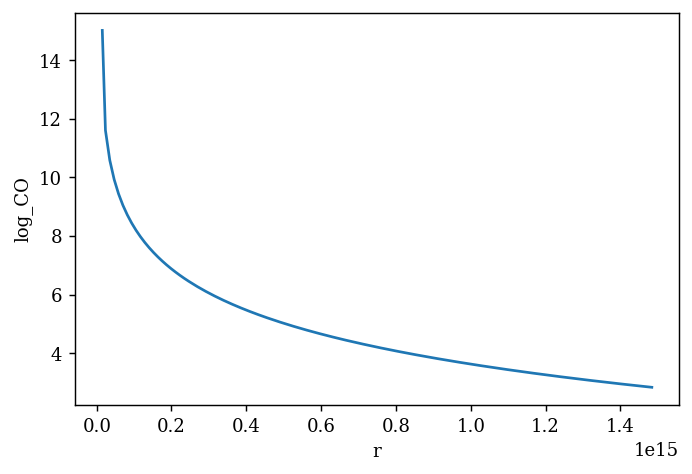

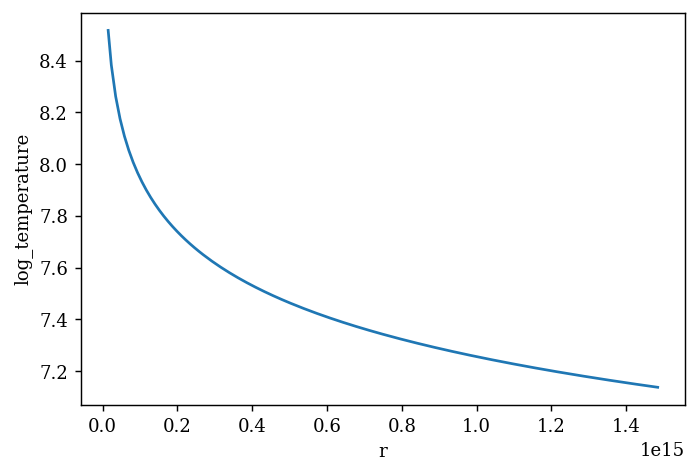

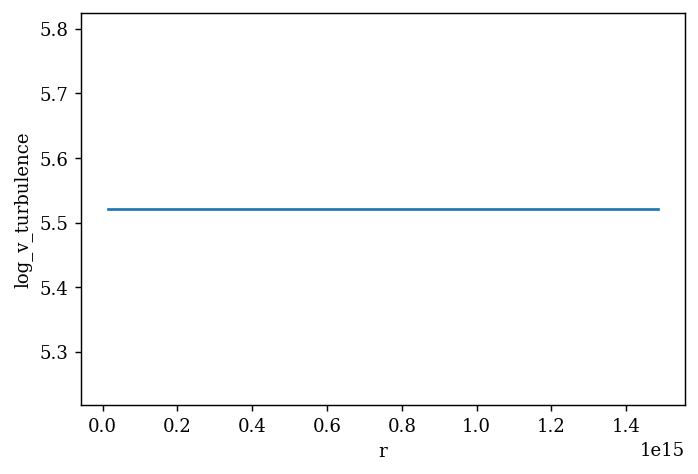

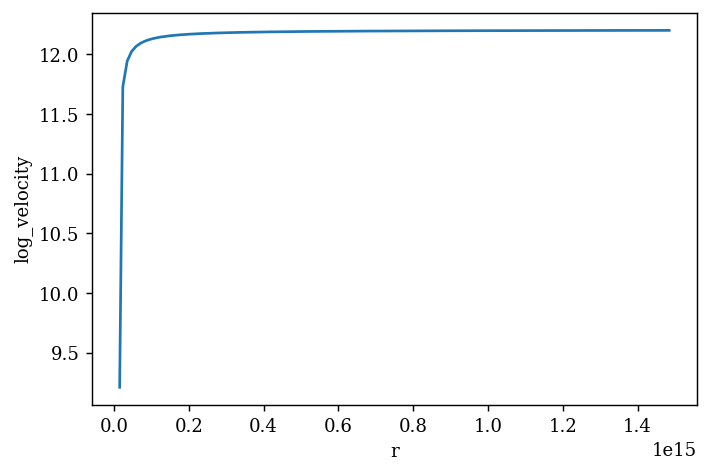

In [23]:
spherical.plot()

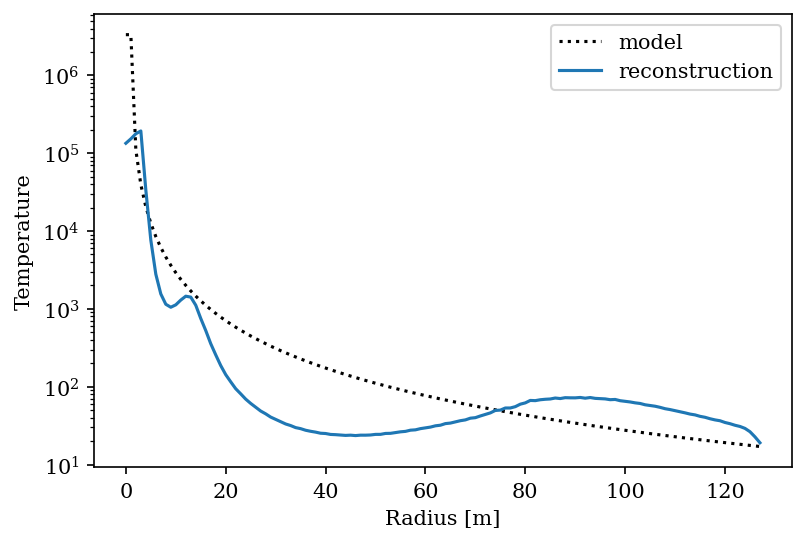

In [36]:
plt.figure(dpi=150)
plt.plot(torch.exp(spherical_model.model_1D['log_CO']).data, c='k', linestyle=':', label='model')
plt.plot(torch.exp(spherical.model_1D['log_CO']).data, label='reconstruction')
plt.yscale('log')
plt.ylabel('Temperature')
plt.xlabel('Radius [m]')
plt.legend()

NameError: name 'temperature' is not defined

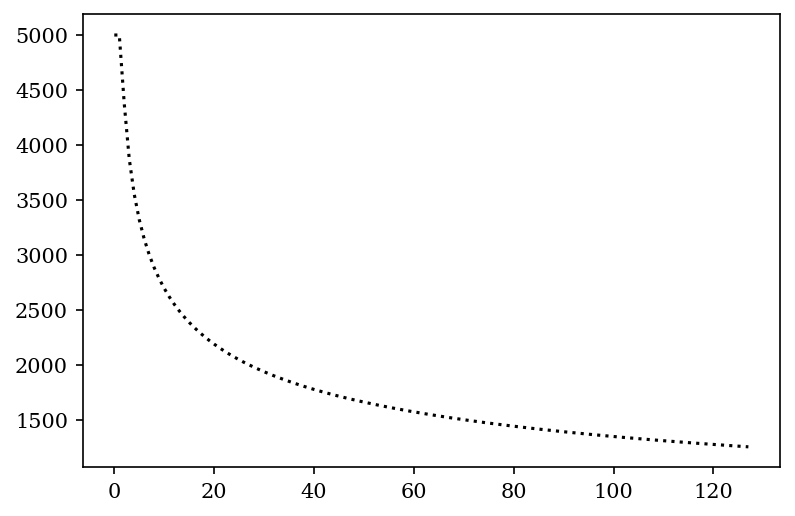

In [14]:
plt.figure(dpi=150)
plt.plot(torch.exp(spherical_model.model_1D['log_temperature']).data, c='k', linestyle=':', label='model')
plt.plot(temperature.data, label='reconstruction')
plt.yscale('log')
plt.ylabel('Temperature')
plt.xlabel('Radius [m]')
plt.legend()

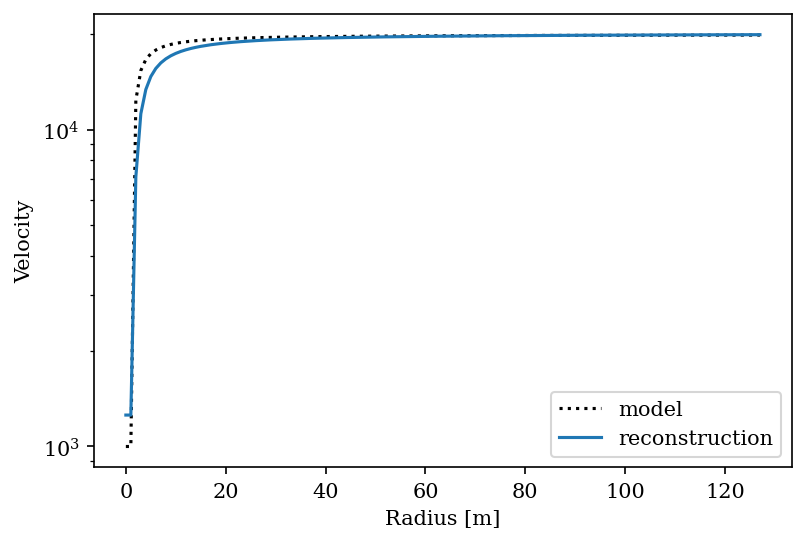

In [ ]:
plt.figure(dpi=150)
plt.plot(v_fac * torch.exp(spherical_model.model_1D['log_velocity']).data, c='k', linestyle=':', label='model')
plt.plot(velocity.data, label='reconstruction')
plt.yscale('log')
plt.ylabel('Velocity')
plt.xlabel('Radius [m]')
plt.legend()

In [37]:
spherical.model_1D.save('models/test_model_all_CO_25_beta_0.9_epsilon_0.85_10_lines.h5')